# Credit Card Fraud Detection

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Acknowledgement
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
rcParams['figure.figsize'] = 8, 6
RANDOM_SEED = 42
LABELS = ["Regular","Fraud"]

In [5]:
data = pd.read_csv("creditcard.csv")

data.head()

## Data Preprocessing

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
data.isnull().values.sum()

0

Text(0, 0.5, 'Number of Times')

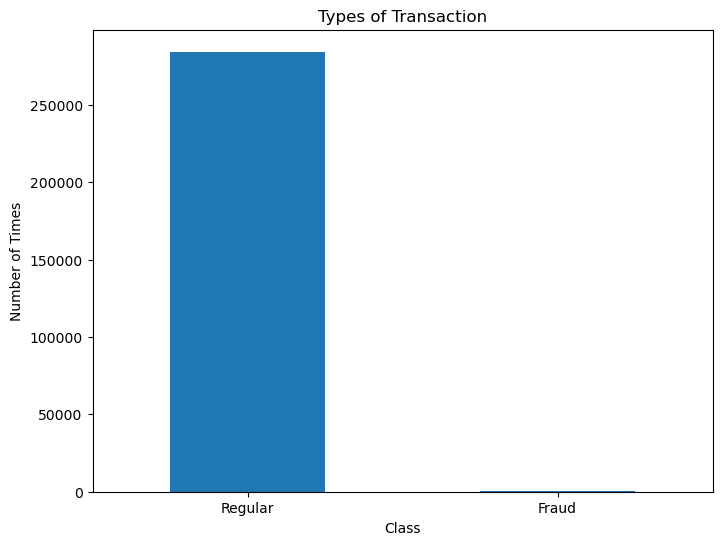

In [9]:
class_count = pd.value_counts(data["Class"], sort = True)
class_count.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Types of Transaction")
plt.xlabel("Class")
plt.ylabel("Number of Times")

## Data Analysis

In [10]:
fraud_data = data[data["Class"] == 1]
reg_data = data[data["Class"] == 0]

In [11]:
fraud_data.shape

(492, 31)

In [12]:
reg_data.shape

(284315, 31)

In [13]:
fraud_data.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
reg_data.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

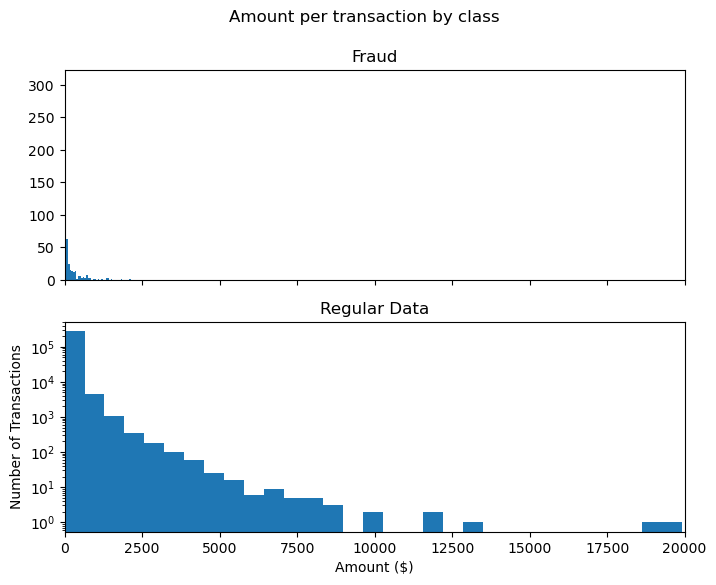

In [15]:
f, (ax1, ax2) = plt.subplots(2,1, sharex = True)
f.suptitle("Amount per transaction by class")
bins = 40
ax1.hist(fraud_data.Amount, bins= bins)
ax1.set_title("Fraud")
ax2.hist(reg_data.Amount, bins = bins)
ax2.set_title("Regular Data")
plt.xlabel("Amount ($)")
plt.ylabel("Number of Transactions")
plt.xlim((0,20000))
plt.yscale("log")
plt.show()


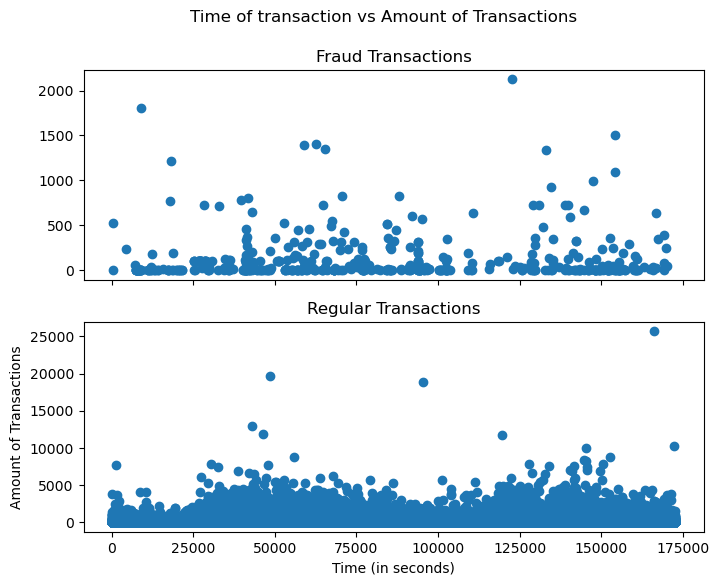

In [16]:
f, (ax1, ax2) = plt.subplots(2,1, sharex = True)
f.suptitle("Time of transaction vs Amount of Transactions")
ax1.scatter(fraud_data.Time, fraud_data.Amount)
ax2.scatter(reg_data.Time, reg_data.Amount)
ax1.set_title("Fraud Transactions")
ax2.set_title("Regular Transactions")
plt.xlabel("Time (in seconds)")
plt.ylabel("Amount of Transactions")
plt.show()

In [17]:
data_1 = data.sample(frac = 0.1, random_state = 42)

In [18]:
print(data_1.shape, data.shape)

(28481, 31) (284807, 31)


In [19]:
fraud = data_1[data_1.Class ==1]
reg = data_1[data_1.Class == 0]

In [20]:
outlier_fraction = len(fraud)/(float(len(reg)))

In [21]:
print("Outlier Fraction in the Data : ", outlier_fraction)
print("Total Fraud Cases : ", len(fraud))
print("Total Non-Fraud Cases : ", len(reg))

Outlier Fraction in the Data :  0.001617724635132759
Total Fraud Cases :  46
Total Non-Fraud Cases :  28435


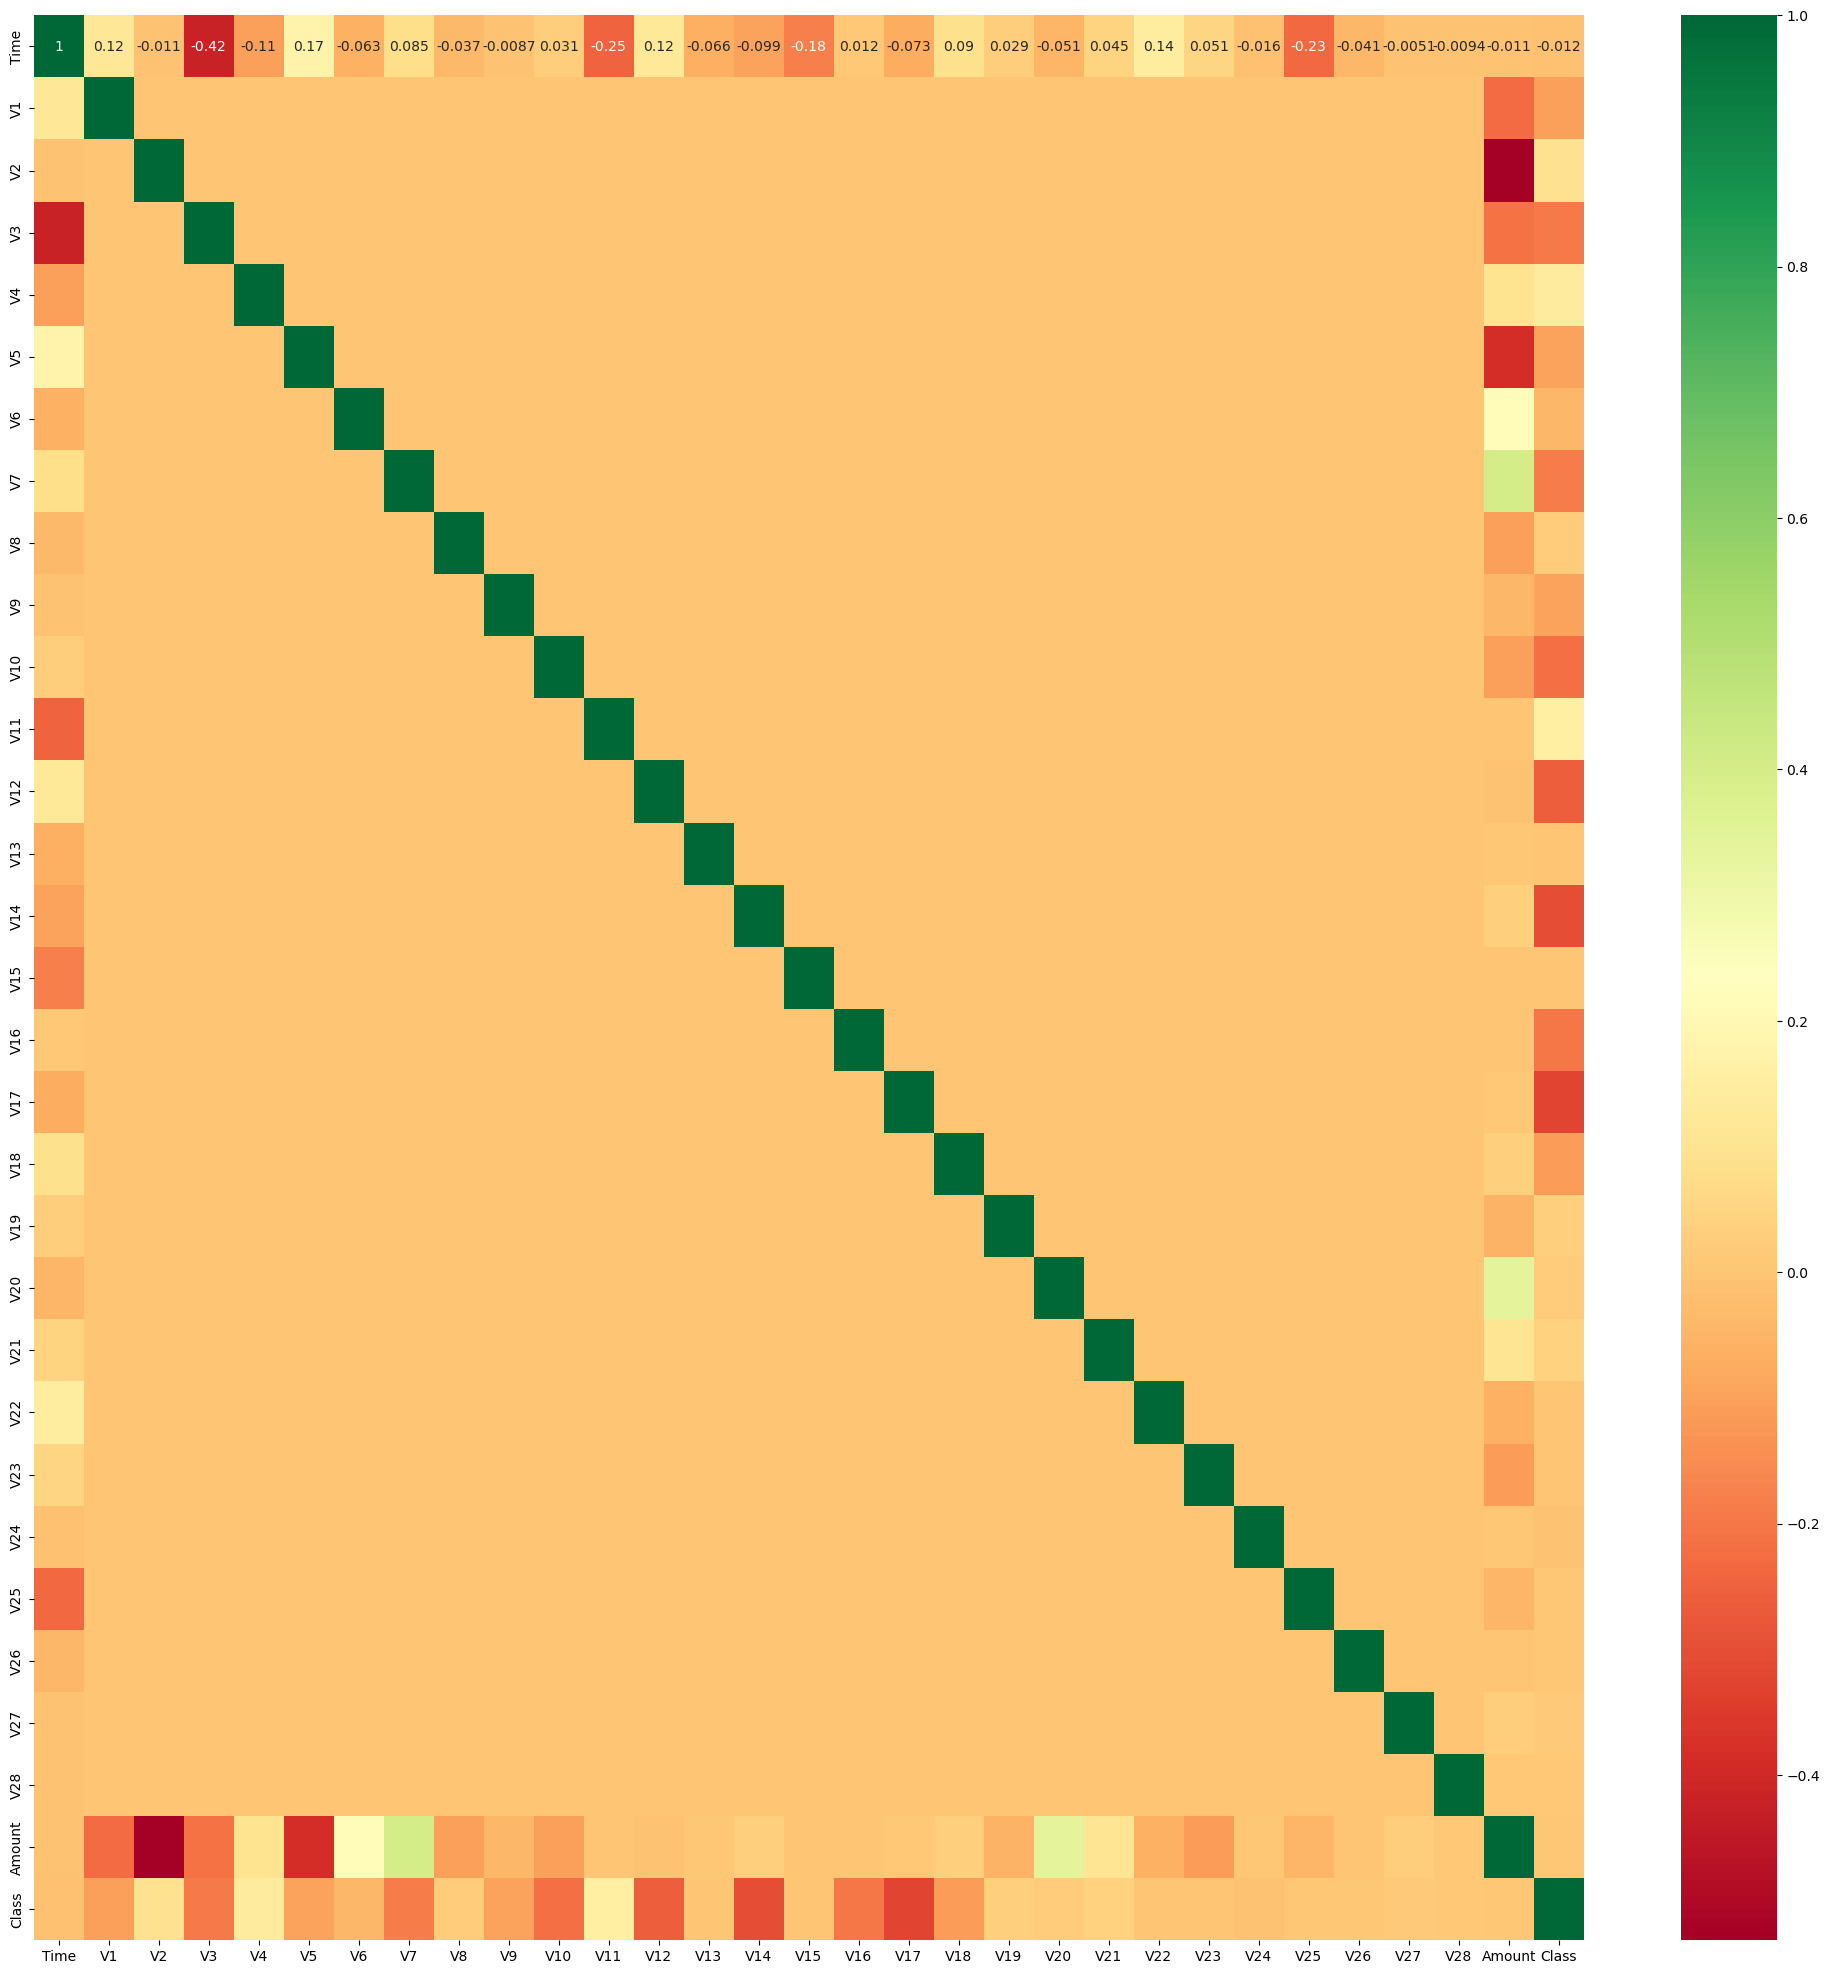

In [22]:
corrmat = data_1.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (25,25))
g = sns.heatmap(data[top_corr_features].corr(), annot = True, cmap = "RdYlGn")

In [23]:
columns = data_1.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]
state = np.random.RandomState(42)
X = data_1[columns]
Y = data_1["Class"]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


## Model Prediction

### We will use Isolation Forest Algorithm for this dataset.
#### Isolation Forest Algorithm
The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

##### How Isolation Forests Work 
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.


In [38]:
model = IsolationForest(n_estimators=100, max_samples=len(X),contamination=outlier_fraction, verbose=0)

In [41]:
model.fit(X)
scores_prediction = model.decision_function(X)
y_pred = model.predict(X)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y).sum()
print("{}: {}".format("Isolation Forest Algorithm",n_errors))
print("Accuracy Score :")
print(accuracy_score(Y,y_pred))
print("Classification Report :")
print(classification_report(Y,y_pred))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest Algorithm: 59
Accuracy Score :
0.9979284435237527
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.36      0.37      0.37        46

    accuracy                           1.00     28481
   macro avg       0.68      0.68      0.68     28481
weighted avg       1.00      1.00      1.00     28481



### Observations :
1. Isolation Forest detected 59 errors in our dataset.
2. This model gained an accuracy of 99.79 % accuracy in detecting the outliers of our dataset.
3. We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases.
   
####    In this way, Isolation Forest Algorithm can be used for the anomaly detection problems. This helps in predicting outliers in a more efficient way and requires less memory to compute as well in compared with other anomaly detecting classifiers.